# Compare Pre-sources wrt Sources

 work with Weakly_2023_44
- use jupyter kernel LSST


- author : Sylvie Dagoret-Campagne
- affiliation : IJCLab
- creation date : 2023/01/03
- update : 2023/01/03


In [33]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm,SymLogNorm


import matplotlib.ticker                         # here's where the formatter is
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
from astropy.visualization import (MinMaxInterval, SqrtStretch,ZScaleInterval,PercentileInterval,
                                   ImageNormalize,imshow_norm)
from astropy.visualization.stretch import SinhStretch, LinearStretch,AsinhStretch,LogStretch
from astropy.io import fits
import astropy.coordinates as coord
import astropy.units as u
import pandas as pd

import matplotlib.ticker                         # here's where the formatter is
import os
import re
import pandas as pd
import pickle

plt.rcParams["figure.figsize"] = (4,4)
plt.rcParams["axes.labelsize"] = 'xx-large'
plt.rcParams['axes.titlesize'] = 'xx-large'
plt.rcParams['xtick.labelsize']= 'xx-large'
plt.rcParams['ytick.labelsize']= 'xx-large'

In [3]:
import lsst.daf.butler as dafButler
#import lsst.summit.utils.butlerUtils as butlerUtils

In [4]:
#repo =  "/sdf/group/rubin/repo/main"
repo = "/sdf/group/rubin/repo/oga/"
butler = dafButler.Butler(repo)
registry = butler.registry
my_collection = "LATISS/runs/AUXTEL_DRP_IMAGING_2023-11A-10A-09AB-08ABC-07AB-05AB/w_2023_46/PREOPS-4553"

In [5]:
def get_corners_radec(wcs, bbox):
    """
    Return the corners in RA,Dec in degrees given the WCS and bounding box for an image.

    Parameters
    ----------
    wcs: image WCS returned by the Butler
    bbox: bounding box returned by the Butler

    Returns
    -------
    corners_ra, corners_dec in decimal degrees
    """

    corners_x = [bbox.beginX, bbox.beginX, bbox.endX, bbox.endX]
    corners_y = [bbox.beginY, bbox.endY, bbox.endY, bbox.beginY]
    corners_ra = []
    corners_dec = []
    for i in range(4):
        radec = wcs.pixelToSky(corners_x[i], corners_y[i])
        corners_ra.append(radec.getRa().asDegrees())
        corners_dec.append(radec.getDec().asDegrees())
    
    return corners_ra, corners_dec

In [6]:
def get_bbox_radec(wcs, bbox):
    """
    Return the corners in RA,Dec in degrees given the WCS and bounding box for an image.

    Parameters
    ----------
    wcs: image WCS returned by the Butler
    bbox: bounding box returned by the Butler

    Returns
    -------
    ramin,ramax,decmin,decmax in decimal degrees
    """

    xmin = bbox.beginX
    xmax = bbox.endX
    ymin = bbox.beginY
    ymax = bbox.endY
    
    radec_ll = wcs.pixelToSky(xmin, ymin)
    radec_ur = wcs.pixelToSky(xmax, ymax)
        
    return radec_ur.getRa().asDegrees(),radec_ll.getRa().asDegrees(), radec_ll.getDec().asDegrees(),radec_ur.getDec().asDegrees() 

In [7]:
def isradec_inbbox_radec(ra,dec,wcs, bbox):
    """
    Return the corners in RA,Dec in degrees given the WCS and bounding box for an image.

    Parameters
    ----------
    ra: ra in degree
    dec: dec in degree
    wcs: image WCS returned by the Butler
    bbox: bounding box returned by the Butler

    Returns
    -------
    Bool
    
    """

    RAMIN,RAMAX,DECMIN,DECMAX = get_bbox_radec(wcs, bbox)

    assert RAMIN < RAMAX
    assert DECMIN < DECMAX

    flag = (ra >= RAMIN) and (ra<=RAMAX) and (dec>= DECMIN) and (dec <= DECMAX) 
    return flag

In [8]:
def FindTractAndPatch(row):
    """
    Apply this function on ccdvisitTable dataframe to find the tract and patch for each visit
    """
    tractsId_list = list(tracts_patchs_dict.keys())   
    try:
        ra = row["ra"]
        dec = row["dec"]
        selectFlag = False
        # loop on tract
        for tractID in tractsId_list:
            wcs = tractsInfoWCS_dict[tractID]
            tractInfo = tractsInfo_dict[tractID] 
            patches_selected = list(tracts_patchs_dict[tractID])
            # loop on patches
            for patch in tractInfo:
                patchID = patch.getSequentialIndex()
                if patchID in patches_selected:
                    ibb=patch.getInnerBBox()
                    flag = isradec_inbbox_radec(ra,dec,wcs, ibb)
                    selectFlag =  selectFlag or flag
                    if selectFlag:
                        return pd.Series([tractID,patchID])
        return pd.Series([0,0])           
                
    except Exception as inst:
        print(type(inst))    # the exception type
        print(inst.args)     # arguments stored in .args
        print(inst)          # __str__ allows args to be printed directly,
        return pd.Series([0,0])  

In [9]:
def convert_fluxtomag(x) :
    """
    The object and source catalogs store only fluxes. There are hundreds of flux-related columns, 
    and to store them also as magnitudes would be redundant, and a waste of space.
    All flux units are nanojanskys. The AB Magnitudes Wikipedia page provides a concise resource 
    for users unfamiliar with AB magnitudes and jansky fluxes. To convert to AB magnitudes use:
    As demonstrated in Section 2.3.2, to add columns of magnitudes after retrieving columns of flux, users can do this:
    results_table['r_calibMag'] = -2.50 * numpy.log10(results_table['r_calibFlux']) + 31.4
    results_table['r_cModelMag'] = -2.50 * numpy.log10(results_table['r_cModelFlux']) + 31.4
    (from DP0 tutorial)
    """
    return -2.50 * np.log10(x) + 31.4

## Config

### Skymap

In [10]:
skymap_auxtel ='latiss_v1'
skymap = butler.get('skyMap', skymap=skymap_auxtel, collections=my_collection)

### Tract and Patches

In [11]:
with open('Latiss_tractspatchs.pickle', 'rb') as handle:
    tracts_patchs_dict = pickle.load(handle)

In [12]:
tractsInfo_dict = {}
tractsInfoWCS_dict = {}
tractsId_list = list(tracts_patchs_dict.keys())

# loop to select the good tracts
for tractInfo in skymap:
    tractID = tractInfo.getId()
    # is this tract in Auxtel tract list
    if tractID in tractsId_list:
        # keep tractInfo
        tractsInfo_dict[tractID] = tractInfo 
        # keep WCS
        tractsInfoWCS_dict[tractID] = tractInfo.getWcs()


### Sources and PreSources

In [13]:
filepresource_in="preSourceTable_202312.csv"
filesource_in="sourceTable_202312.csv"

## Read Data

In [14]:
df_pres = pd.read_csv(filepresource_in)
df_src = pd.read_csv(filesource_in)

In [15]:
df_src.head()

,sourceId,coord_ra,coord_dec,ccdVisitId,parentSourceId,x,y,xErr,yErr,ra,...,hsmShapeRegauss_flag_parent_source,sky_source,detect_isPrimary,visit,detector,band,physical_filter,visid_idx,dateobs,mjd
0,175077975606165505,270.123104,-25.026300,41741842176,0,28.000000,36.000000,NaN,NaN,270.123104,...,False,False,True,2023081700503,0,g,SDSSg_65mm~empty,0,2023-08-18 04:24:02.590,60174.183363
1,175077975606165506,270.146958,-25.025264,41741842176,0,841.356901,65.210897,0.281312,0.237931,270.146958,...,False,False,True,2023081700503,0,g,SDSSg_65mm~empty,0,2023-08-18 04:24:02.590,60174.183363
2,175077975606165507,270.185965,-25.025121,41741842176,0,2170.703580,54.321945,0.036102,0.031955,270.185965,...,False,False,True,2023081700503,0,g,SDSSg_65mm~empty,0,2023-08-18 04:24:02.590,60174.183363
3,175077975606165508,270.214024,-25.025078,41741842176,0,3126.911888,43.979312,0.029372,0.025076,270.214024,...,False,False,True,2023081700503,0,g,SDSSg_65mm~empty,0,2023-08-18 04:24:02.590,60174.183363
4,175077975606165509,270.227852,-25.025344,41741842176,0,3598.000000,28.000000,NaN,NaN,270.227852,...,False,False,True,2023081700503,0,g,SDSSg_65mm~empty,0,2023-08-18 04:24:02.590,60174.183363


In [16]:
df_pres.head()

,sourceId,coord_ra,coord_dec,ccdVisitId,parentSourceId,x,y,xErr,yErr,ra,...,hsmShapeRegauss_flag_parent_source,sky_source,detect_isPrimary,visit,detector,band,physical_filter,visid_idx,dateobs,mjd
0,174092471737778177,240.035971,-24.102006,41506879744,0,971.000000,18.000000,NaN,NaN,240.035971,...,False,False,True,2023072000185,0,i,SDSSi_65mm~empty,0,2023-07-21 01:18:49.927,60146.054745
1,174092471737778178,240.114481,-24.101061,41506879744,0,3668.000000,18.000000,NaN,NaN,240.114481,...,False,False,True,2023072000185,0,i,SDSSi_65mm~empty,0,2023-07-21 01:18:49.927,60146.054745
2,174092471737778179,240.050174,-24.100808,41506879744,0,1459.423140,56.758008,0.218000,0.190530,240.050174,...,False,False,True,2023072000185,0,i,SDSSi_65mm~empty,0,2023-07-21 01:18:49.927,60146.054745
3,174092471737778180,240.056853,-24.100218,41506879744,0,1689.114439,75.950081,0.339048,0.381324,240.056853,...,False,False,True,2023072000185,0,i,SDSSi_65mm~empty,0,2023-07-21 01:18:49.927,60146.054745
4,174092471737778181,240.095234,-24.099785,41506879744,0,3007.604922,74.842679,0.366987,0.293205,240.095234,...,False,False,True,2023072000185,0,i,SDSSi_65mm~empty,0,2023-07-21 01:18:49.927,60146.054745


In [17]:
df_p = df_pres[['sourceId','ccdVisitId','x','y','ra','dec','coord_ra','coord_dec','psfFlux','gaussianFlux','visit','band','visid_idx','mjd','dateobs','extendedness_flag','detect_isPrimary']]

In [18]:
df_s = df_src[['sourceId','ccdVisitId','x','y','ra','dec','coord_ra','coord_dec','psfFlux','gaussianFlux','visit','band','visid_idx','mjd','dateobs','extendedness_flag','detect_isPrimary']]

In [19]:
df_s["psfMag"] =  df_s['psfFlux'].map(convert_fluxtomag)
#df_sel["gaussianMag"] =  df_sel['gaussianFlux'].map(lambda x:-2.50 * np.log10(x) + 31.4)
df_s["gaussianMag"] =  df_s['gaussianFlux'].map(convert_fluxtomag)

df_p["psfMag"] =  df_p['psfFlux'].map(convert_fluxtomag)
#df_sel["gaussianMag"] =  df_sel['gaussianFlux'].map(lambda x:-2.50 * np.log10(x) + 31.4)
df_p["gaussianMag"] =  df_p['gaussianFlux'].map(convert_fluxtomag)

/tmp/ipykernel_41354/4088867659.py:12: RuntimeWarning: invalid value encountered in log10
  return -2.50 * np.log10(x) + 31.4
/tmp/ipykernel_41354/1289463486.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_s["psfMag"] =  df_s['psfFlux'].map(convert_fluxtomag)
/tmp/ipykernel_41354/4088867659.py:12: RuntimeWarning: invalid value encountered in log10
  return -2.50 * np.log10(x) + 31.4
/tmp/ipykernel_41354/4088867659.py:12: RuntimeWarning: divide by zero encountered in log10
  return -2.50 * np.log10(x) + 31.4
/tmp/ipykernel_41354/1289463486.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pan

In [20]:
df_s= df_s[df_s['extendedness_flag']==False & df_s['detect_isPrimary']]
df_s.dropna(axis=0,inplace = True)

In [21]:
df_p = df_p[df_p['extendedness_flag']==False & df_p['detect_isPrimary']]
df_p.dropna(axis=0,inplace = True)

## Merge

In [22]:
df_m = df_p.merge(df_s, left_on='sourceId', right_on='sourceId',suffixes=('_p', '_s'))

In [24]:
df_m.head()

,sourceId,ccdVisitId_p,x_p,y_p,ra_p,dec_p,coord_ra_p,coord_dec_p,psfFlux_p,gaussianFlux_p,...,gaussianFlux_s,visit_s,band_s,visid_idx_s,mjd_s,dateobs_s,extendedness_flag_s,detect_isPrimary_s,psfMag_s,gaussianMag_s
0,174092471737778179,41506879744,1459.423140,56.758008,240.050174,-24.100808,240.050174,-24.100808,1.199960e+06,1.232448e+06,...,1.210818e+06,2023072000185,i,42,60146.054745,2023-07-21 01:18:49.927,False,True,16.221307,16.192303
1,174092471737778180,41506879744,1689.114439,75.950081,240.056853,-24.100218,240.056853,-24.100218,3.211502e+05,3.671762e+05,...,3.616223e+05,2023072000185,i,42,60146.054745,2023-07-21 01:18:49.927,False,True,17.649778,17.504362
2,174092471737778181,41506879744,3007.604922,74.842679,240.095234,-24.099785,240.095234,-24.099785,6.535161e+05,6.485894e+05,...,6.501823e+05,2023072000185,i,42,60146.054745,2023-07-21 01:18:49.927,False,True,16.859196,16.867412
3,174092471737778182,41506879744,1067.365729,85.899514,240.038750,-24.100168,240.038750,-24.100168,2.687373e+05,2.940699e+05,...,2.881895e+05,2023072000185,i,42,60146.054745,2023-07-21 01:18:49.927,False,True,17.848611,17.750804
4,174092471737778183,41506879744,1015.704829,101.648672,240.037240,-24.099767,240.037240,-24.099767,1.462395e+05,1.497408e+05,...,1.467319e+05,2023072000185,i,42,60146.054745,2023-07-21 01:18:49.927,False,True,18.509377,18.483688


In [37]:
#list_cols = list(df_m.columns)
#for e in list_cols:
#    print(e)

In [38]:
df_m["ra"] = df_m["ra_s"]
df_m["dec"] = df_m["dec_s"]

In [39]:
df_m[["patchID","tractID"]] = df_m.apply( FindTractAndPatch, axis=1,result_type ='expand')

In [40]:
df_m

,sourceId,ccdVisitId_p,x_p,y_p,ra_p,dec_p,coord_ra_p,coord_dec_p,psfFlux_p,gaussianFlux_p,...,mjd_s,dateobs_s,extendedness_flag_s,detect_isPrimary_s,psfMag_s,gaussianMag_s,ra,dec,patchID,tractID
0,174092471737778179,41506879744,1459.423140,56.758008,240.050174,-24.100808,240.050174,-24.100808,1.199960e+06,1.232448e+06,...,60146.054745,2023-07-21 01:18:49.927,False,True,16.221307,16.192303,240.050174,-24.100808,5615,274
1,174092471737778180,41506879744,1689.114439,75.950081,240.056853,-24.100218,240.056853,-24.100218,3.211502e+05,3.671762e+05,...,60146.054745,2023-07-21 01:18:49.927,False,True,17.649778,17.504362,240.056853,-24.100218,5615,274
2,174092471737778181,41506879744,3007.604922,74.842679,240.095234,-24.099785,240.095234,-24.099785,6.535161e+05,6.485894e+05,...,60146.054745,2023-07-21 01:18:49.927,False,True,16.859196,16.867412,240.095234,-24.099785,5615,274
3,174092471737778182,41506879744,1067.365729,85.899514,240.038750,-24.100168,240.038750,-24.100168,2.687373e+05,2.940699e+05,...,60146.054745,2023-07-21 01:18:49.927,False,True,17.848611,17.750804,240.038750,-24.100168,5615,275
4,174092471737778183,41506879744,1015.704829,101.648672,240.037240,-24.099767,240.037240,-24.099767,1.462395e+05,1.497408e+05,...,60146.054745,2023-07-21 01:18:49.927,False,True,18.509377,18.483688,240.037240,-24.099767,5615,275
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
880964,176062681684379021,41976614400,1721.220185,3900.456386,270.243207,-24.928944,270.243207,-24.928944,5.797227e+05,5.812273e+05,...,60202.105496,2023-09-15 02:31:54.880,False,True,16.990624,16.987809,270.243207,-24.928944,5634,91
880965,176062681684379022,41976614400,1734.660929,3941.651923,270.243586,-24.927845,270.243586,-24.927845,2.781668e+05,2.709826e+05,...,60202.105496,2023-09-15 02:31:54.880,False,True,17.788521,17.816931,270.243586,-24.927845,5634,91
880966,176062681684379023,41976614400,1612.620766,3897.192739,270.240025,-24.929067,270.240025,-24.929067,2.301183e+05,2.213865e+05,...,60202.105496,2023-09-15 02:31:54.880,False,True,17.994551,18.036550,270.240025,-24.929067,5634,91
880967,176062681684379025,41976614400,1274.442138,3912.159875,270.230110,-24.928780,270.230110,-24.928780,4.203320e+05,6.785856e+05,...,60202.105496,2023-09-15 02:31:54.880,False,True,17.342736,16.822705,270.230110,-24.928780,5634,91


## Plot

<Axes: xlabel='ccdVisitId_p', ylabel='ccdVisitId_s'>

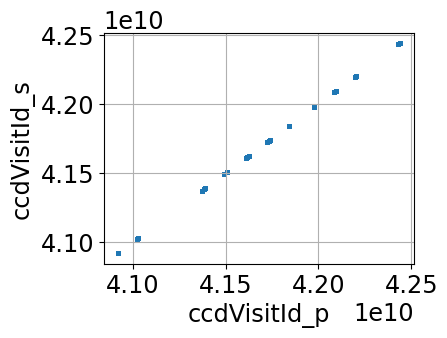

In [30]:
df_m.plot.scatter(x="ccdVisitId_p", y="ccdVisitId_s",marker=".",grid=True)

<Axes: xlabel='coord_ra_p', ylabel='coord_ra_s'>

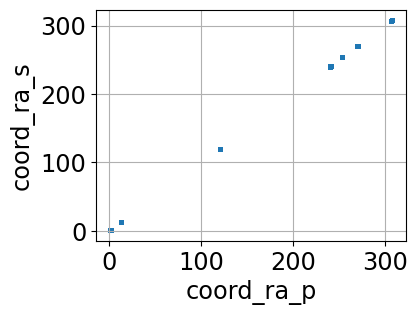

In [31]:
df_m.plot.scatter(x="coord_ra_p", y="coord_ra_s",marker=".",grid=True)

<Axes: xlabel='coord_dec_p', ylabel='coord_dec_s'>

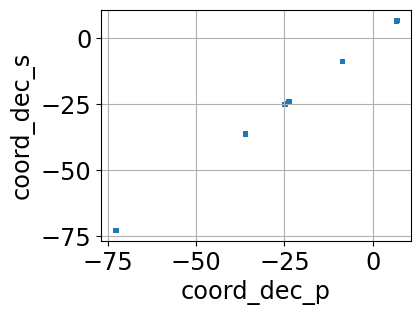

In [32]:
df_m.plot.scatter(x="coord_dec_p", y="coord_dec_s",marker=".",grid=True)

<Axes: title={'center': 'mag sources vs mag pre sources'}, xlabel='psfMag_p', ylabel='psfMag_s'>

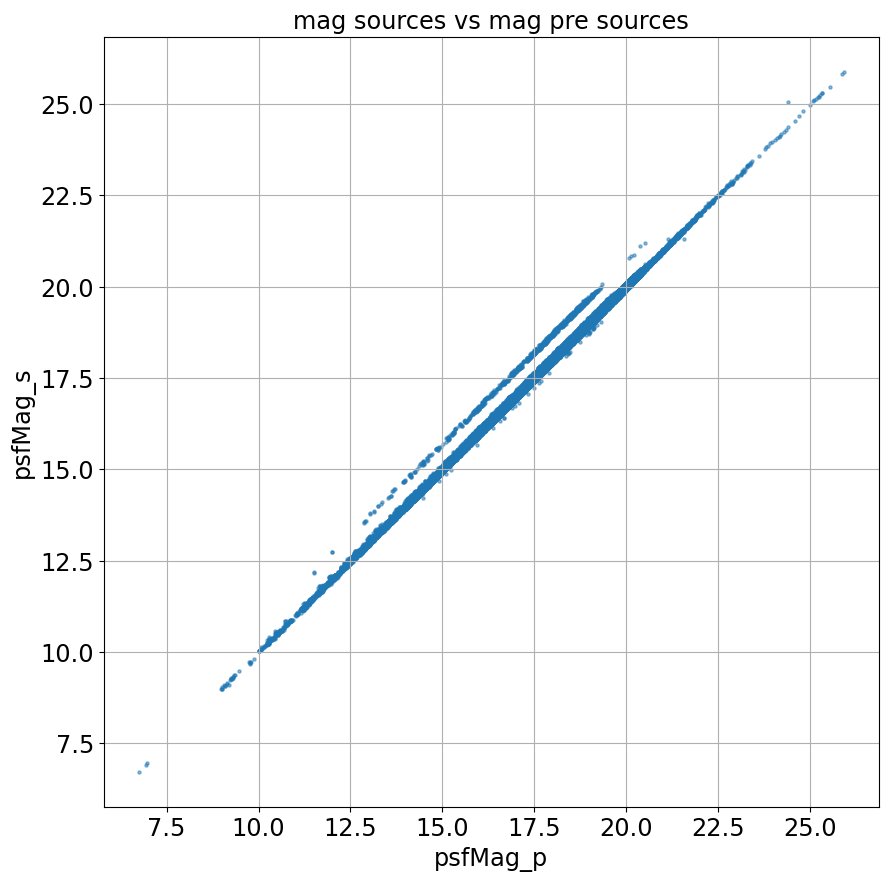

In [27]:
df_m.plot.scatter(x="psfMag_p", y="psfMag_s",marker=".",alpha=0.5,figsize=(10,10),grid=True,title="mag sources vs mag pre sources")

<Axes: title={'center': 'mag sources vs mag pre sources'}, xlabel='gaussianMag_p', ylabel='gaussianMag_s'>

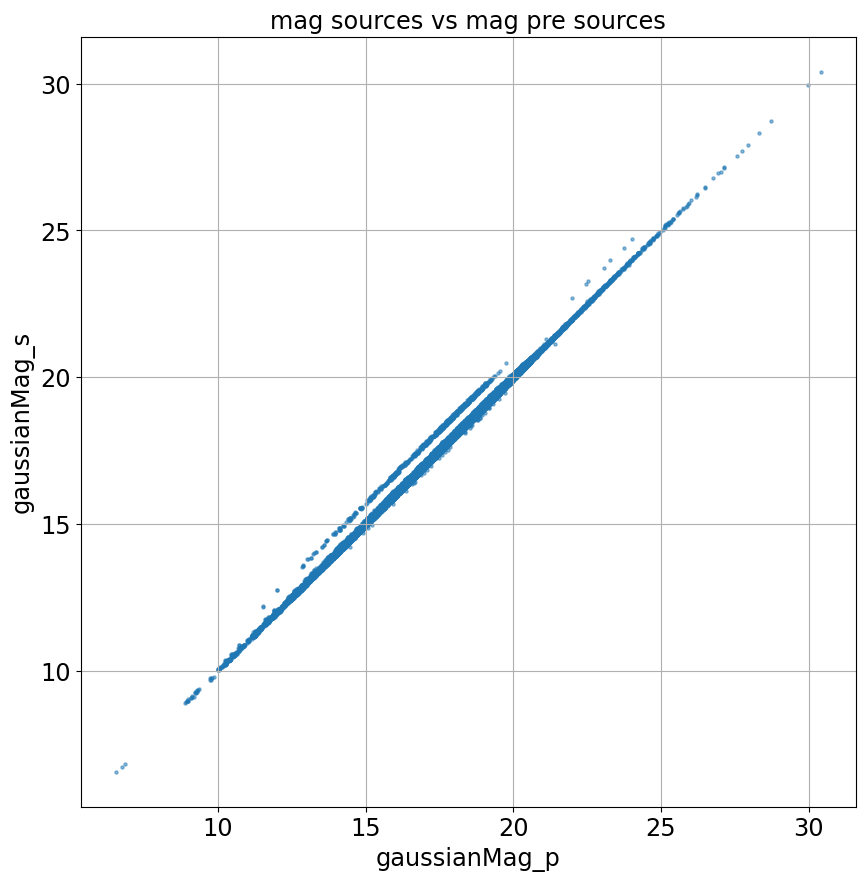

In [28]:
df_m.plot.scatter(x="gaussianMag_p", y="gaussianMag_s",marker=".",alpha=0.5,figsize=(10,10),grid=True,title="mag sources vs mag pre sources")

In [41]:
tract_selected = 5615
patch_selected = 294
suptitle = f"pre-sources and sources in  tract {tract_selected} and patch {patch_selected}"

In [42]:
df_m["selectedFlag"] = df_m[["patchID","tractID"]].apply(lambda x: x[0] == tract_selected and x[1] == patch_selected,axis =1, raw= True )

Text(0.5, 0.98, 'pre-sources and sources in  tract 5615 and patch 294')

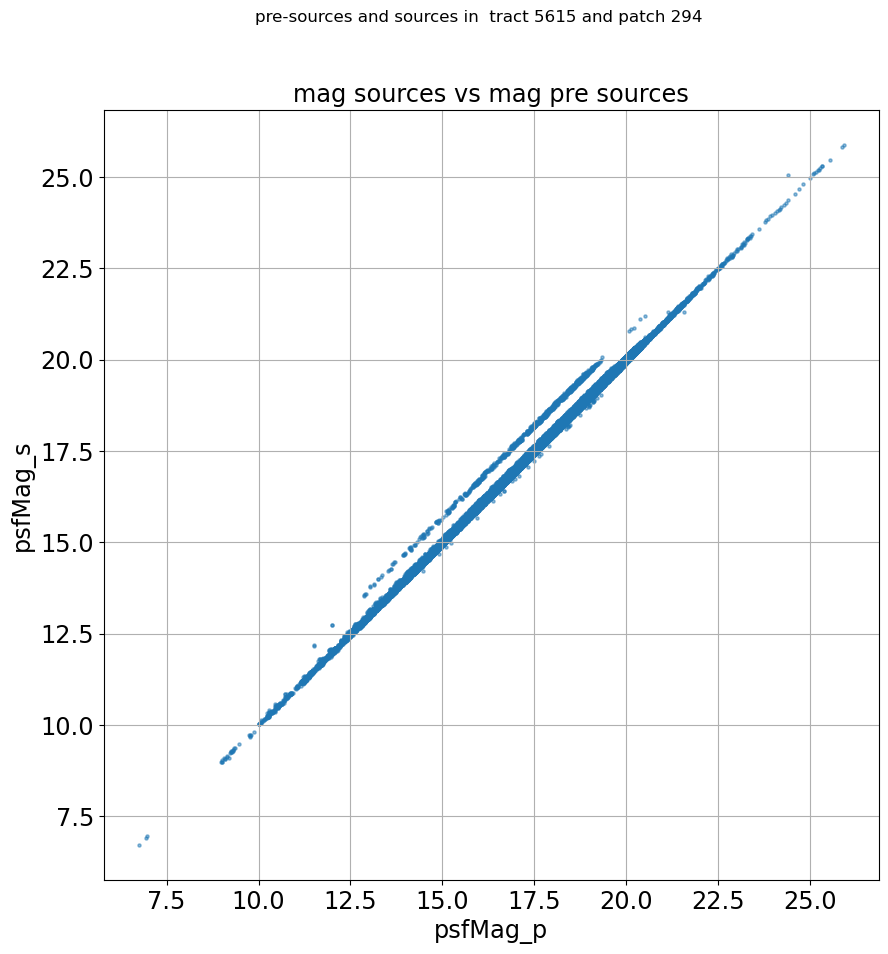

In [45]:
df_m.plot.scatter(x="psfMag_p", y="psfMag_s",marker=".",alpha=0.5,figsize=(10,10),grid=True,title="mag sources vs mag pre sources")
plt.suptitle(suptitle)